In [60]:
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm
import collections
import json


## NUMPY IMPORTS
import pickle
import numpy as np
import math
import pandas as pd
from scipy.misc import imread

import sklearn

# TENSORFLOW
import tensorflow as tf
tf.python.control_flow_ops = tf


## KERAS
from keras.layers.core import Dense, Activation, Flatten, Dropout,Reshape,Lambda
from keras.layers import ELU,normalization
from keras.layers.convolutional import Convolution2D,Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.activations import relu, softmax
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.models import load_model, model_from_json, Sequential




from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import cv2, sys, os


In [61]:
# constants
dataFolderPath = "data3/"
imageFolderPath = "data3/"

In [62]:
df = pd.read_csv(dataFolderPath+"driving_log.csv")

In [76]:
def getModel():
    DATA_HEIGHT =66
    DATA_WIDTH =200
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, name='Conv1', border_mode='same', subsample=(2, 2),input_shape=(DATA_HEIGHT, DATA_WIDTH, 3), activation='relu'))
    model.add(Convolution2D(36, 5, 5, name='Conv2', border_mode='same', subsample=(2, 2)))
    model.add(Convolution2D(48, 5, 5, name='Conv3', border_mode='same', subsample=(2, 2)))
    model.add(Convolution2D(64, 3, 3, name='Conv4', border_mode='same', subsample=(1, 1)))
    model.add(Convolution2D(64, 3, 3, name='Conv5', border_mode='same', subsample=(1, 1)))
    model.add(Flatten(name='Flatten'))
    model.add(Dense(1164, name='Dense1', init='uniform'))
    #model.add(Dropout(0.1))
    model.add(Dense(100, name='Dense2', init='uniform', activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(50, name='Dense3', init='uniform', activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(10, name='Dense4', init='uniform', activation='relu'))

    model.add(Dense(1, name='Dense5', init='uniform', activation='tanh'))
    return model


In [77]:
model = getModel()
if (os.path.isfile("model.h5")):
    model = load_model("model.h5")

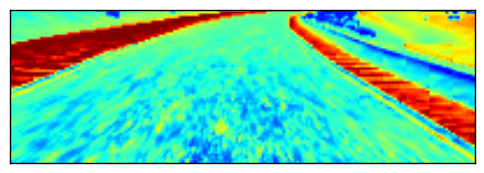

In [66]:
# new_size_col,new_size_row = 64, 64

def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    cols = 320
    rows =160
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


def preprocessImage(image):
    new_size_col = 200
    new_size_row = 66
    shape = image.shape
    image = image[math.floor(shape[0]*0.4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row),interpolation=cv2.INTER_AREA)    
    return image

def processLineData(data):
    randomDirection = np.random.randint(3) # this is to choose a random direction
#     randomDirection = 1 # this is to choose a random direction

#   left
    if (randomDirection == 0):
        pathToImage = data['left'][0].strip()
        errorSteeringAngle = .25
#   center
    if (randomDirection == 1):
        pathToImage = data['center'][0].strip()
        errorSteeringAngle = 0.
#   right
    if (randomDirection == 2):
        pathToImage = data['right'][0].strip()
        errorSteeringAngle = -.25
    
    y_steer = data['steering'][0] + errorSteeringAngle
#     get image
    image = cv2.imread(imageFolderPath+pathToImage)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#     image,y_steer = trans_image(image,y_steer,100)
#     image = add_random_shadow(image)
#     image = augment_brightness_camera_images(image)
    image = preprocessImage(image)
#     image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = y_steer *-1.0
    
    return image,y_steer



def fixedProcess(data,isFlipped,direction):
#     randomDirection = np.random.randint(3) # this is to choose a random direction
    randomDirection = direction # this is to choose a random direction

#   left
    if (randomDirection == 0):
        pathToImage = data['left'][0].strip()
        errorSteeringAngle = .20
#   center
    if (randomDirection == 1):
        pathToImage = data['center'][0].strip()
        errorSteeringAngle = 0.
#   right
    if (randomDirection == 2):
        pathToImage = data['right'][0].strip()
        errorSteeringAngle = -.20
    
    y_steer = data['steering'][0] + errorSteeringAngle
#     get image
    image = cv2.imread(imageFolderPath+pathToImage)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#     image,y_steer= trans_image(image,y_steer,100)
#     image = augment_brightness_camera_images(image)
    image = preprocessImage(image)
#     image = np.array(image)
#     ind_flip = np.random.randint(2)
    if isFlipped==0:
        image = cv2.flip(image,1)
        y_steer = y_steer *-1.0
    return image,y_steer

img = cv2.imread("data/IMG/center_2016_12_01_13_33_06_717.jpg")
img = preprocessImage(img)
plt.imshow(img[:,:,-1])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [67]:
x_data = []
y_data = []
for i in range(len(df)):
    line_data = df.iloc[[i]].reset_index()
#     for j in range(0,3):
    x,y = fixedProcess(line_data,1,1)
    flipped_x ,flipped_y = fixedProcess(line_data,0,1)
    x_data.append(x)
    y_data.append(y)
    x_data.append(flipped_x)
    y_data.append(flipped_y)
    
x_data = np.array(x_data)
y_data = np.array(y_data)



In [68]:
x_data ,y_data = sklearn.utils.shuffle(x_data ,y_data)

In [78]:
from sklearn.utils import shuffle
BATCH_SIZE = 32
NUM_EPOCHS = 1
LEARNING_RATE = 0.0001
MOMENTUM = 0.01
REGULARIZE_PARAM=0.1
DECAY = 0.0

Adam_optimizer = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=DECAY)

model.compile(optimizer=Adam_optimizer,loss = 'mse',metrics = ['accuracy'])


history = model.fit(x_data, y_data, batch_size=120, nb_epoch=5, validation_split=0.2,shuffle=True)

## when using fit-generator
# def generate_batch_data(data,batch_size = 32):
#     batch_images = np.zeros((batch_size, 66, 200, 3))
#     batch_steering = np.zeros(batch_size)
#     while 1:
#         for i_batch in range(batch_size):
#             i_line = np.random.randint(len(data))## getting a random line from the data set
#             line_data = data.iloc[[i_line]].reset_index()            
#             x,y = processLineData(line_data)
#             batch_images[i_batch] = x
#             batch_steering[i_batch] = y
#         yield batch_images, batch_steering

# batch_size = 100
# model.fit_generator(generate_batch_data(df,batch_size),
#         samples_per_epoch=50000, nb_epoch=30,verbose=1)

Train on 22936 samples, validate on 5734 samples
Epoch 1/5
22936/22936 [==============================] - 2032s - loss: 0.0024 - acc: 0.7456 - val_loss: 0.0158 - val_acc: 0.7410
Epoch 2/5
22936/22936 [==============================] - 794s - loss: 0.0021 - acc: 0.7456 - val_loss: 0.0158 - val_acc: 0.7410
Epoch 3/5
22936/22936 [==============================] - 28938s - loss: 0.0015 - acc: 0.7456 - val_loss: 0.0156 - val_acc: 0.7408
Epoch 4/5
22936/22936 [==============================] - 268s - loss: 0.0012 - acc: 0.7456 - val_loss: 0.0154 - val_acc: 0.7410
Epoch 5/5
22936/22936 [==============================] - 281s - loss: 9.7597e-04 - acc: 0.7456 - val_loss: 0.0158 - val_acc: 0.7412


In [79]:
import json
json_string = model.to_json()
model.save("model.h5")
with open('model.json', 'w') as outfile :
    json.dump(json_string, outfile)

In [ ]:
# from IPython.display import SVG
# from keras.utils.visualize_util import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))